In [1]:

import agama
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams
import copy

from astropy import units as u
from astropy.io import ascii

from configparser import RawConfigParser  # python 3

import pyICs

from galpy.util import bovy_coords
%matplotlib inline

rcParams['font.size'] = 16
rcParams['lines.linewidth'] = 1.5
rcParams['axes.linewidth'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['image.cmap'] = 'magma'

cmap = copy.copy(plt.cm.get_cmap(rcParams['image.cmap']))
cmap.set_bad((0,0,0))
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


According to the Binney tutorial we set up the McMillan 2017 potential.
https://ui.adsabs.harvard.edu/?#abs/2017MNRAS.465...76M/abstract



In [2]:
help(agama.Potential)

Help on class Potential in module agama:

class Potential(builtins.object)
 |  Potential is a class that represents a wide range of gravitational potentials.
 |  There are several ways of initializing the potential instance:
 |    - from a list of key=value arguments that specify an elementary potential class;
 |    - from a tuple of dictionary objects that contain the same list of possible key/value pairs for each component of a composite potential;
 |    - from an INI file with these parameters for one or several components;
 |    - from a file with potential expansion coefficients or an N-body snapshot;
 |    - from a tuple of existing Potential objects created previously (in this case a composite potential is created from these components).
 |  Note that all keywords and their values are not case-sensitive.
 |  
 |  List of possible keywords for a single component:
 |    type='...'   the type of potential, can be one of the following 'basic' types:
 |      Harmonic, Logarithmic, Pl

General AGAMA stuff
---

In [3]:
#1. set units (in Msun, Kpc, km/s)
agama.setUnits(mass=1., length=1., velocity=1.)


'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1 Msun, gravitational constant: 4.30092e-06'

Setting up an existing MW potential
---

In [4]:
pot_MW14 = agama.Potential('MWPotential2014.ini')       # MWPotential2014 
pot_McMillan17 = agama.Potential('McMillan17.ini')      # MW potential from McMillan(2017)

Check that we get nice orbits in both potentials (independent of which we use):

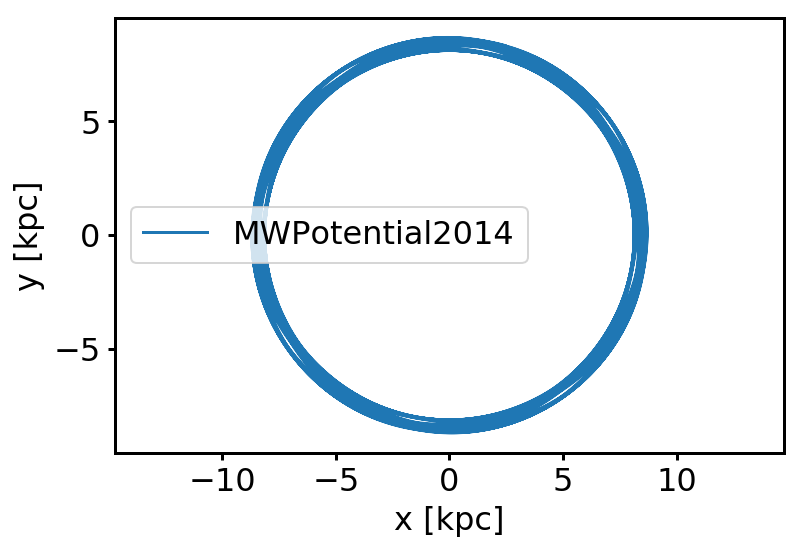

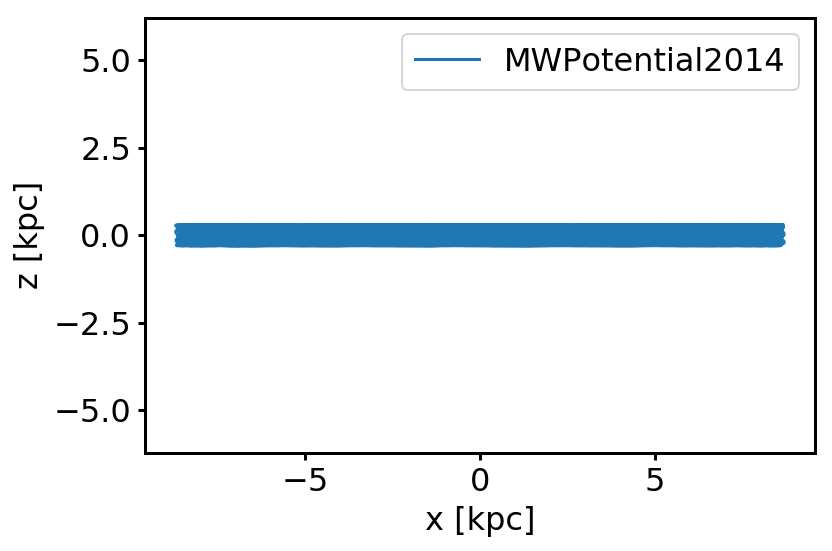

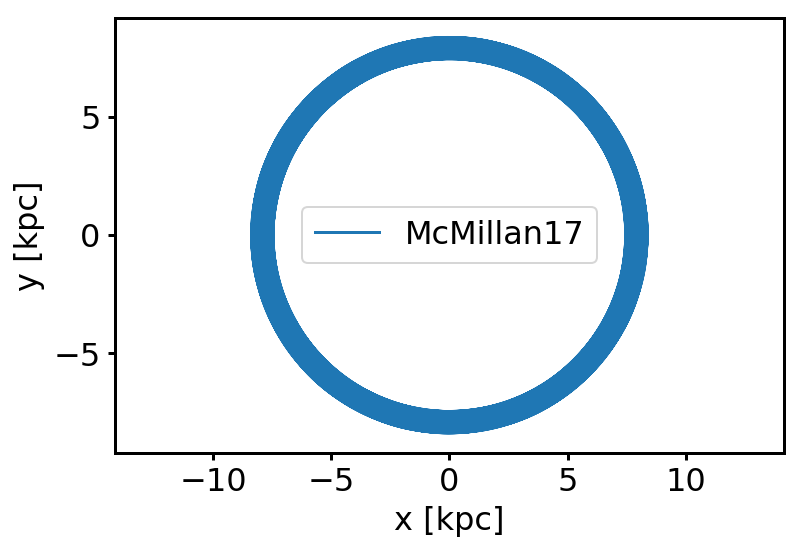

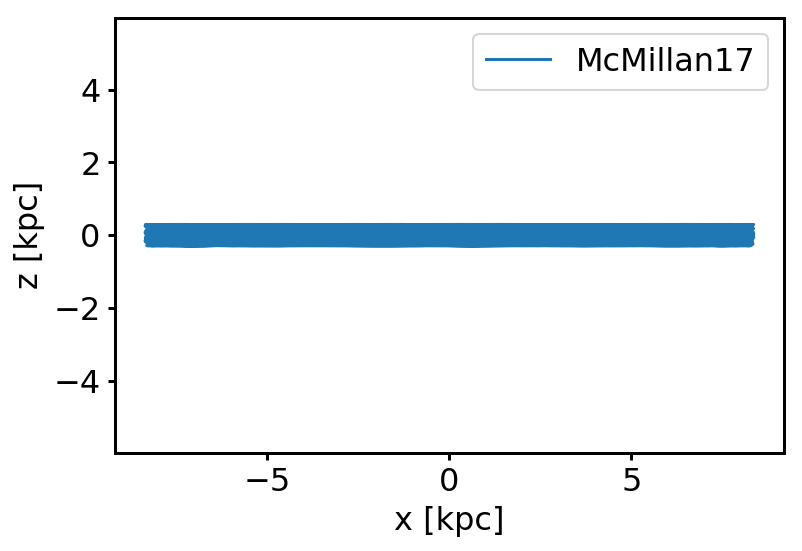

In [5]:
potlist = [pot_MW14, pot_McMillan17]
potnames = ['MWPotential2014', 'McMillan17']
for i in range(len(potlist)):

    times,points = agama.orbit(ic=[-8.3,0,-0.1,-9.4,221,17.9], potential=potlist[i], time =10, trajsize=10001 )
    plt.plot(points[:,0], points[:,1], label = potnames[i])
    plt.xlabel('x [kpc]')
    plt.ylabel('y [kpc]')
    plt.axis('equal')
    plt.legend()
    plt.show()
    plt.plot(points[:,0], points[:,2], label = potnames[i])
    plt.xlabel('x [kpc]')
    plt.ylabel('z [kpc]')
    plt.axis('equal')
    plt.legend()
    plt.show()

Let's see how this SelfConsistentModel works:


In [6]:
help(agama.SelfConsistentModel)

Help on class SelfConsistentModel in module agama:

class SelfConsistentModel(builtins.object)
 |  A class for performing self-consistent modelling procedure.
 |  A full model consists of one or more instances of Component class representing either static density or potential profiles, or distribution function-based components with iteratively recomputed density profiles, plus the overall potential and the associated action finder object.
 |  The SelfConsistentModel object contains parameters for two kinds of potential expansions used in the procedure -- Multipole potential for spheroidal components and CylSpline potential for disk-like components, the list of Component objects, and read-only references to the total potential and the action finder.
 |  The constructor takes named arguments describing the potential expansion parameters -- a full list is given by 'dir(SelfConsistentModel)', and they may be modified at any time.
 |  The list of components is initially empty and should be 

In [7]:
# copied from https://github.com/GalacticDynamics-Oxford/Agama/blob/master/py/example_self_consistent_model.py
def printoutInfo(model, iteration):
    densDisk = model.components[0].getDensity()
    densBulge= model.components[1].getDensity()
    densHalo = model.components[2].getDensity()
    pt0 = (solarRadius, 0, 0)
    pt1 = (solarRadius, 0, 1)
    print("Disk total mass=%g Msun, rho(Rsolar,z=0)=%g, rho(Rsolar,z=1kpc)=%g Msun/pc^3" % \
        (densDisk.totalMass(), densDisk.density(pt0)*1e-9, densDisk.density(pt1)*1e-9))  # per pc^3, not kpc^3
    print("Halo total mass=%g Msun, rho(Rsolar,z=0)=%g, rho(Rsolar,z=1kpc)=%g Msun/pc^3" % \
        (densHalo.totalMass(), densHalo.density(pt0)*1e-9, densHalo.density(pt1)*1e-9))
    print("Potential at origin=-(%g km/s)^2, total mass=%g Msun" % \
        ((-model.potential.potential(0,0,0))**0.5, model.potential.totalMass()))
    densDisk.export ("dens_disk_" +iteration);
    densBulge.export("dens_bulge_"+iteration);
    densHalo.export ("dens_halo_" +iteration);
    model.potential.export("potential_"+iteration);
    """writeRotationCurve("rotcurve_"+iteration, (model.potential[1],  # disk potential (CylSpline)
        agama.Potential(type='Multipole', lmax=6, density=densBulge),        # -"- bulge
        agama.Potential(type='Multipole', lmax=6, density=densHalo) ) )      # -"- halo"""



In [8]:
# copied from https://github.com/GalacticDynamics-Oxford/Agama/blob/master/py/example_self_consistent_model.py
iniFileName = "SCM.ini"
ini = RawConfigParser()
ini.optionxform=str  # do not convert key to lowercase
ini.read(iniFileName)
iniPotenThinDisk = dict(ini.items("Potential thin disk"))
iniPotenThickDisk= dict(ini.items("Potential thick disk"))
iniPotenGasDisk  = dict(ini.items("Potential gas disk"))
iniPotenBulge    = dict(ini.items("Potential bulge"))
iniPotenDarkHalo = dict(ini.items("Potential dark halo"))
iniDFThinDisk    = dict(ini.items("DF thin disk"))
iniDFThickDisk   = dict(ini.items("DF thick disk"))
iniDFStellarHalo = dict(ini.items("DF stellar halo"))
iniDFDarkHalo    = dict(ini.items("DF dark halo"))
iniDFBulge       = dict(ini.items("DF bulge"))
iniSCMHalo       = dict(ini.items("SelfConsistentModel halo"))
iniSCMBulge      = dict(ini.items("SelfConsistentModel bulge"))
iniSCMDisk       = dict(ini.items("SelfConsistentModel disk"))
iniSCM           = dict(ini.items("SelfConsistentModel"))
solarRadius      = ini.getfloat("Data", "SolarRadius")
model = agama.SelfConsistentModel(**iniSCM)

# create initial ('guessed') density profiles of all components
densityBulge       = agama.Density(**iniPotenBulge)
densityDarkHalo    = agama.Density(**iniPotenDarkHalo)
densityThinDisk    = agama.Density(**iniPotenThinDisk)
densityThickDisk   = agama.Density(**iniPotenThickDisk)
densityGasDisk     = agama.Density(**iniPotenGasDisk)
densityStellarDisk = agama.Density(densityThinDisk, densityThickDisk)  # composite

# add components to SCM - at first, all of them are static density profiles
model.components.append(agama.Component(density=densityStellarDisk, disklike=True))
model.components.append(agama.Component(density=densityBulge,       disklike=False))
model.components.append(agama.Component(density=densityDarkHalo,    disklike=False))
model.components.append(agama.Component(density=densityGasDisk,     disklike=True))

# compute the initial potential
model.iterate()
printoutInfo(model, "init")

print("\033[1;33m**** STARTING MODELLING ****\033[0m\nInitial masses of density components: " \
    "Mdisk=%g Msun, Mbulge=%g Msun, Mhalo=%g Msun, Mgas=%g Msun" % \
    (densityStellarDisk.totalMass(), densityBulge.totalMass(), \
    densityDarkHalo.totalMass(), densityGasDisk.totalMass()))

# create the dark halo DF
dfHalo  = agama.DistributionFunction(potential=model.potential, **iniDFDarkHalo)
# same for the bulge
dfBulge = agama.DistributionFunction(potential=model.potential, **iniDFBulge)
# same for the stellar components (thin/thick disks and stellar halo)
dfThinDisk    = agama.DistributionFunction(potential=model.potential, **iniDFThinDisk)
dfThickDisk   = agama.DistributionFunction(potential=model.potential, **iniDFThickDisk)
dfStellarHalo = agama.DistributionFunction(potential=model.potential, **iniDFStellarHalo)
# composite DF of all stellar components except the bulge
dfStellar     = agama.DistributionFunction(dfThinDisk, dfThickDisk, dfStellarHalo)
# composite DF of all stellar components including the bulge
dfStellarAll  = agama.DistributionFunction(dfThinDisk, dfThickDisk, dfStellarHalo, dfBulge)

# replace the disk, halo and bulge SCM components with the DF-based ones
model.components[0] = agama.Component(df=dfStellar, disklike=True, **iniSCMDisk)
model.components[1] = agama.Component(df=dfBulge, disklike=False, **iniSCMBulge)
model.components[2] = agama.Component(df=dfHalo,  disklike=False, **iniSCMHalo)

# we can compute the masses even though we don't know the density profile yet
print("Masses of DF components: " \
    "Mdisk=%g Msun (Mthin=%g, Mthick=%g, Mstel.halo=%g); Mbulge=%g Msun; Mdarkhalo=%g Msun" % \
    (dfStellar.totalMass(), dfThinDisk.totalMass(), dfThickDisk.totalMass(), \
    dfStellarHalo.totalMass(), dfBulge.totalMass(), dfHalo.totalMass()))

# do a few more iterations to obtain the self-consistent density profile for the entire system
for iteration in range(1,6):
    print("\033[1;37mStarting iteration #%d\033[0m" % iteration)
    model.iterate()
    printoutInfo(model, "iter"+str(iteration))

Disk total mass=4.51289e+10 Msun, rho(Rsolar,z=0)=0.0442617, rho(Rsolar,z=1kpc)=0.00359074 Msun/pc^3
Halo total mass=1.08388e+12 Msun, rho(Rsolar,z=0)=0.0099717, rho(Rsolar,z=1kpc)=0.00985799 Msun/pc^3
Potential at origin=-(533.915 km/s)^2, total mass=1.14819e+12 Msun
**** STARTING MODELLING ****
Initial masses of density components: Mdisk=4.51289e+10 Msun, Mbulge=8.84166e+09 Msun, Mhalo=1.08388e+12 Msun, Mgas=1.03637e+10 Msun
Masses of DF components: Mdisk=6.20895e+10 Msun (Mthin=3.49225e+10, Mthick=1.00249e+10, Mstel.halo=1.71421e+10); Mbulge=9.13887e+09 Msun; Mdarkhalo=1.06716e+12 Msun
Starting iteration #1
Disk total mass=5.27559e+10 Msun, rho(Rsolar,z=0)=0.0585023, rho(Rsolar,z=1kpc)=0.00353542 Msun/pc^3
Halo total mass=1.06814e+12 Msun, rho(Rsolar,z=0)=0.0104954, rho(Rsolar,z=1kpc)=0.0102995 Msun/pc^3
Potential at origin=-(539.324 km/s)^2, total mass=1.14032e+12 Msun
Starting iteration #2
Disk total mass=5.28161e+10 Msun, rho(Rsolar,z=0)=0.0600639, rho(Rsolar,z=1kpc)=0.00351865 M

In [9]:
DM = agama.GalaxyModel(potential = model.potential, df = dfHalo)
bulge = agama.GalaxyModel(potential = model.potential, df = dfBulge)
thindisk = agama.GalaxyModel(potential = model.potential, df = dfThinDisk)
thickdisk = agama.GalaxyModel(potential = model.potential, df = dfThickDisk)


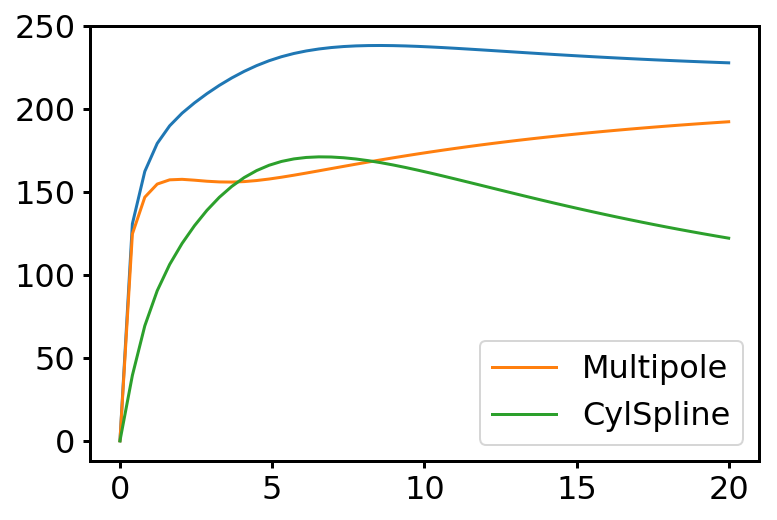

In [10]:
r = np.linspace(0,20)
points = np.column_stack((r, r*0, r*0))
plt.plot(r, np.sqrt(-r*model.potential.force(points)[:,0]))
for pot in model.potential: plt.plot(r, np.sqrt(-r*pot.force(points)[:,0]), label = pot.name())
plt.legend()
plt.show()

The mass given in sample adds up to the total mass of the component and gives each particle an equal amount.

Now, let's sample $10^5$ particles for each the halo, thin disk and bulge and $10^4$ particles for the thick disk. These samples include pos [kpc], vel [km/s] and mass [M$_\odot$].

In [11]:
DMsample = DM.sample(100000)
bulgesample = bulge.sample(100000)
thindisksample = thindisk.sample(100000)
thickdisksample = thickdisk.sample(10000)

In [12]:
samples = [DMsample, bulgesample, thindisksample, thickdisksample]
positions = []
velocities = []
masses = []
for sample in samples:
    positions.append(sample[0][:,0:3])
    velocities.append(sample[0][:,3:])
    masses.append(sample[1])

mass = []
for i in masses:
    for j in range(len(i)):
        mass.append(i[j])

        # probably need to go one dimension deeper for position and velocity and reshape them in the end!
position = []
for i in positions:
    for j in range(len(i)):
        position.append(i[j])
        
velocity = []
for i in velocities:
    for j in range(len(i)):
        velocity.append(i[j])

mass = np.array(mass)
position = np.array(position)
velocity = np.array(velocity)

In [13]:
data = [position[:,0], position[:,1], position[:,2], velocity[:,0], velocity[:,1], velocity[:,2], mass]
ascii.write(data, 'MWparticles.dat', names=['x', 'y', 'z', 'vx', 'vy', 'vz','mass'])


/u/milas/conda-envs/auriga/lib/python3.6/site-packages/astropy/io/ascii/ui.py:706: AstropyDeprecationWarning: MWparticles.dat already exists. Automatically overwriting ASCII files is deprecated. Use the argument 'overwrite=True' in the future.
  output), AstropyDeprecationWarning)



Sagittarius initital conditions
--
Disk:

$M_\star \approx 10^8\mathrm{M}_\odot$ 

$R_d = 1\mathrm{kpc}$

$h_d = 0.2 (-\ 0.4)\mathrm{kpc}$ - check this with the vertical dispersion which should be around $\sigma_z = 10 \mathrm{km/s}$


Halo:

$M_{200} \approx 6\cdot10^{10}\mathrm{M}_\odot$
or equally $\rho = 7757523.3$

$R_{DM}$ has to be calculated by Justin's script (see below) $\rightarrow R_{DM} = 7.3\mathrm{kpc}$

$\alpha = 1, \beta = 3$


R_200: 80.94301036937837
coreNFW scale length: 7.31353814092
coreNFW density parameter: 7757523.33028
/u/milas/conda-envs/auriga/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



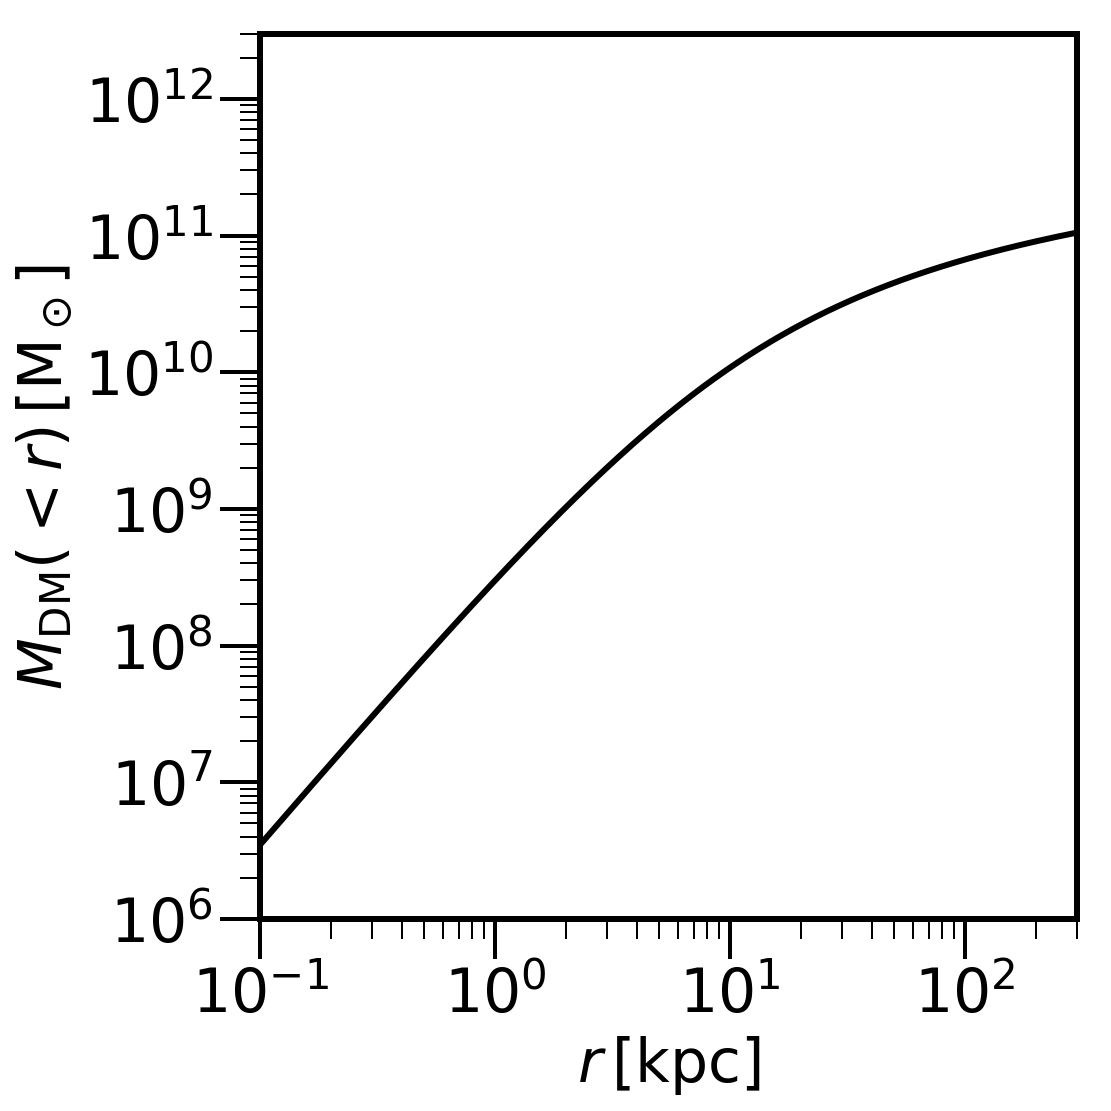

In [14]:
%run nfwcalculator.py

We now get a sample of Sagittarius stars (sample size = $10^4$).

In [15]:
sag_pot = agama.Potential('Sagittarius.ini')

Calculate density profile of tihs potential to compare it to the senity profile of the DF as a test of the DF.

/u/milas/conda-envs/auriga/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



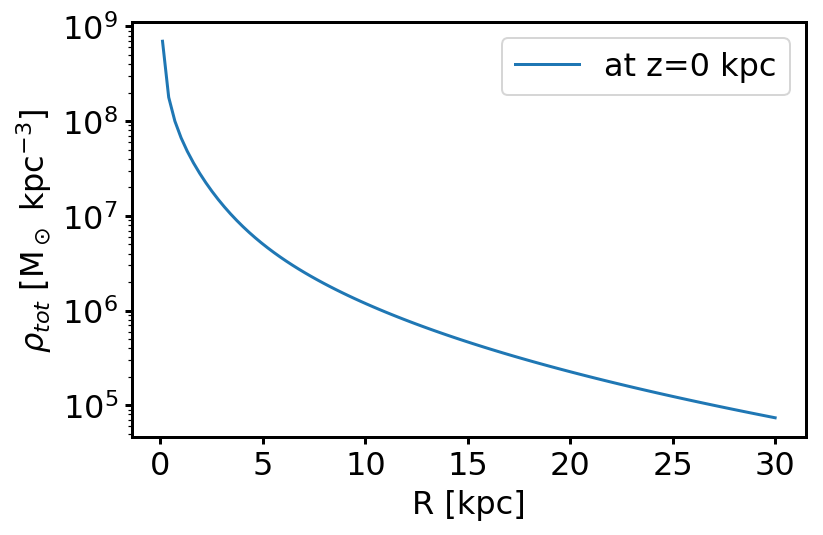

In [16]:
# array of positions at which to evaluate density
R_test = np.linspace(0.1, 30, num = 100)
z_test = np.full(100, 0)
# R = np.sqrt(x**2 + y**2)
R_test_squared = R_test**2
x_test_squared = np.random.sample(100) * R_test_squared
y_test_squared = R_test_squared - x_test_squared
x_test = np.sqrt(x_test_squared)
y_test = np.sqrt(y_test_squared)

x_othertest = np.zeros(100)
y_othertest = np.zeros(100)
z_othertest = np.linspace(0.1, 20, num = 100)

pos = np.array([x_test, y_test, z_test])
pos_test = []
for i in range(len(pos[0])):
    pos_test.append([x_test[i], y_test[i], z_test[i]])

posother = np.array([x_test, y_test, z_test])
pos_othertest = []
for i in range(len(posother[0])):
    pos_othertest.append([x_othertest[i], y_othertest[i], z_othertest[i]])


dens_test = sag_pot.density(pos_test)
dens_othertest = sag_pot.density(pos_othertest)

plt.semilogy(R_test, dens_test, label = 'at z=0 kpc')
plt.xlabel("R [kpc]")
plt.ylabel('$\\rho_{tot}\ [\mathrm{M}_\odot\ \mathrm{kpc}^{-3}] $')
plt.legend()
'''
plt.show()
plt.semilogy(z_othertest, dens_othertest, label = 'at R=0 kpc')
plt.xlabel("z [kpc]")
plt.ylabel('$\\rho_{tot}\ [\mathrm{M}_\odot\ \mathrm{kpc}^{-3}] $')
plt.legend()
'''
plt.show()

/u/milas/conda-envs/auriga/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



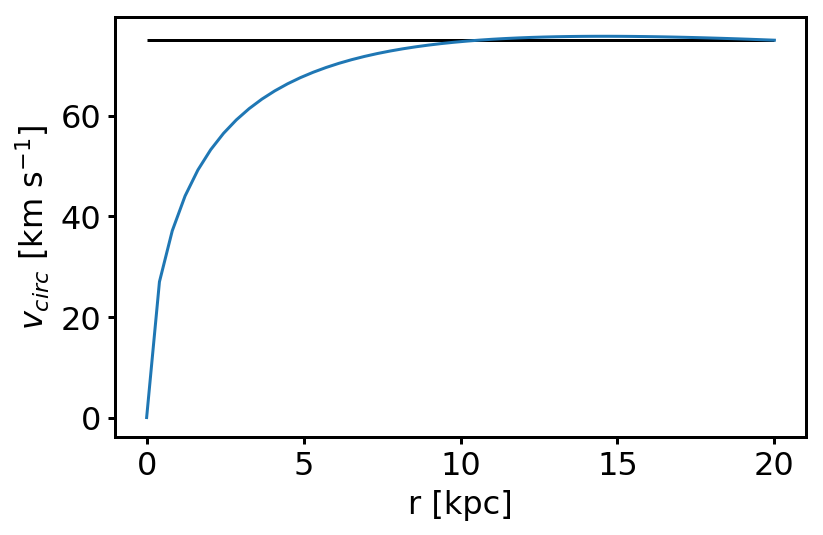

In [17]:
# get the circular velocity curve
r = np.linspace(0,20)
points = np.column_stack((r, r*0, r*0))
plt.plot(r, np.sqrt(-r*sag_pot.force(points)[:,0]))
'''
for pot in sag_pot: 
    plt.plot(r, np.sqrt(-r*pot.force(points)[:,0]), label = pot.name())
    print(pot.name())
'''
plt.hlines(75,0,20)
plt.xlabel('r [kpc]')
plt.ylabel('$v_{circ}\ [\mathrm{km\ s^{-1}}]$')
plt.show()

In [18]:
# this result does not really make sense
import scipy.integrate as integrate
result = integrate.quad(lambda z: sag_pot.density(0,0, z), -np.inf, np.inf)
print(result)

/u/milas/conda-envs/auriga/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)

(2985210296.7148085, 1107618528.2180488)


Sagittarius SelfConsistent Model
---

Think of DFs for Sagittarius disk and halo.

Halos DF is a DoublePowerLaw and for the disk we take a QuasiIsothermal DF. (results see SagittariusSCM.ini)

Now, let's do the Self Consistent Model for Sagittarius


In [19]:
def printoutInfoSag(model, iteration):
    densDisk = model.components[0].getDensity()
    densHalo = model.components[1].getDensity()
    pt0 = (solarRadius, 0, 0)
    pt1 = (solarRadius, 0, 1)
    print("Disk total mass=%g Msun, rho(Rsolar,z=0)=%g, rho(Rsolar,z=1kpc)=%g Msun/pc^3" % \
        (densDisk.totalMass(), densDisk.density(pt0)*1e-9, densDisk.density(pt1)*1e-9))  # per pc^3, not kpc^3
    print("Halo total mass=%g Msun, rho(Rsolar,z=0)=%g, rho(Rsolar,z=1kpc)=%g Msun/pc^3" % \
        (densHalo.totalMass(), densHalo.density(pt0)*1e-9, densHalo.density(pt1)*1e-9))
    print("Potential at origin=-(%g km/s)^2, total mass=%g Msun" % \
        ((-model.potential.potential(0,0,0))**0.5, model.potential.totalMass()))
    densDisk.export ("dens_disk_" +iteration);
    densHalo.export ("dens_halo_" +iteration);
    model.potential.export("potential_"+iteration);
    """writeRotationCurve("rotcurve_"+iteration, (model.potential[1],  # disk potential (CylSpline)
        agama.Potential(type='Multipole', lmax=6, density=densHalo) ) )      # -"- halo"""



In [20]:
iniFileName = "SagittariusSCM.ini"
ini = RawConfigParser()
ini.optionxform=str  # do not convert key to lowercase
ini.read(iniFileName)
iniPotenThinDisk = dict(ini.items("Potential disk"))
iniPotenDarkHalo = dict(ini.items("Potential halo"))
iniDFThinDisk    = dict(ini.items("DF thin disk"))
iniDFDarkHalo    = dict(ini.items("DF dark halo"))
iniSCMHalo       = dict(ini.items("SelfConsistentModel halo"))
iniSCMDisk       = dict(ini.items("SelfConsistentModel disk"))
iniSCM           = dict(ini.items("SelfConsistentModel"))
solarRadius      = ini.getfloat("Data", "SolarRadius")
model = agama.SelfConsistentModel(**iniSCM)

# create initial ('guessed') density profiles of all components
densityDarkHalo    = agama.Density(**iniPotenDarkHalo)
densityThinDisk    = agama.Density(**iniPotenThinDisk)

# add components to SCM - at first, all of them are static density profiles
model.components.append(agama.Component(density=densityThinDisk,    disklike=True))
model.components.append(agama.Component(density=densityDarkHalo,    disklike=False))

# compute the initial potential
model.iterate()
printoutInfoSag(model, "init")

print("\033[1;33m**** STARTING MODELLING ****\033[0m\nInitial masses of density components: " \
    "Mdisk=%g Msun, Mhalo=%g Msun" % \
    (densityThinDisk.totalMass(), densityDarkHalo.totalMass()))

# create the dark halo DF
dfHalo  = agama.DistributionFunction(potential=model.potential, **iniDFDarkHalo)
# same for the stellar components (thin/thick disks and stellar halo)
dfThinDisk    = agama.DistributionFunction(potential=model.potential, **iniDFThinDisk)
# composite DF of all stellar components except the bulge
dfStellar     = dfThinDisk
# composite DF of all stellar components including the bulge
dfStellarAll  = dfStellar

# replace the disk, halo and bulge SCM components with the DF-based ones
model.components[0] = agama.Component(df=dfStellar, disklike=True, **iniSCMDisk)
model.components[1] = agama.Component(df=dfHalo,   disklike=False, **iniSCMHalo)

# we can compute the masses even though we don't know the density profile yet
print("Masses of DF components: " \
    "Mdisk=%g Msun; Mdarkhalo=%g Msun" % \
    (dfStellar.totalMass(), dfHalo.totalMass()))

# do a few more iterations to obtain the self-consistent density profile for the entire system
for iteration in range(1,6):
    print("\033[1;37mStarting iteration #%d\033[0m" % iteration)
    model.iterate()
    printoutInfoSag(model, "iter"+str(iteration))

Disk total mass=9.99998e+07 Msun, rho(Rsolar,z=0)=9.88817e-06, rho(Rsolar,z=1kpc)=6.6626e-08 Msun/pc^3
Halo total mass=6.00001e+10 Msun, rho(Rsolar,z=0)=0.00176959, rho(Rsolar,z=1kpc)=0.00174313 Msun/pc^3
Potential at origin=-(153.787 km/s)^2, total mass=6.01011e+10 Msun
**** STARTING MODELLING ****
Initial masses of density components: Mdisk=9.99998e+07 Msun, Mhalo=6.00001e+10 Msun
Masses of DF components: Mdisk=1.87454e+08 Msun; Mdarkhalo=6.66667e+10 Msun
Starting iteration #1
Disk total mass=1.87381e+08 Msun, rho(Rsolar,z=0)=1.23801e-05, rho(Rsolar,z=1kpc)=1.54512e-08 Msun/pc^3
Halo total mass=6.71746e+10 Msun, rho(Rsolar,z=0)=0.0014744, rho(Rsolar,z=1kpc)=0.00144782 Msun/pc^3
Potential at origin=-(143.642 km/s)^2, total mass=6.75008e+10 Msun
Starting iteration #2
Disk total mass=1.87369e+08 Msun, rho(Rsolar,z=0)=1.09237e-05, rho(Rsolar,z=1kpc)=1.28156e-08 Msun/pc^3
Halo total mass=6.65371e+10 Msun, rho(Rsolar,z=0)=0.00134936, rho(Rsolar,z=1kpc)=0.00132391 Msun/pc^3
Potential at ori

In [21]:
SagDM = agama.GalaxyModel(potential = model.potential, df = dfHalo)
Sagdisk = agama.GalaxyModel(potential = model.potential, df = dfThinDisk)


/u/milas/conda-envs/auriga/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



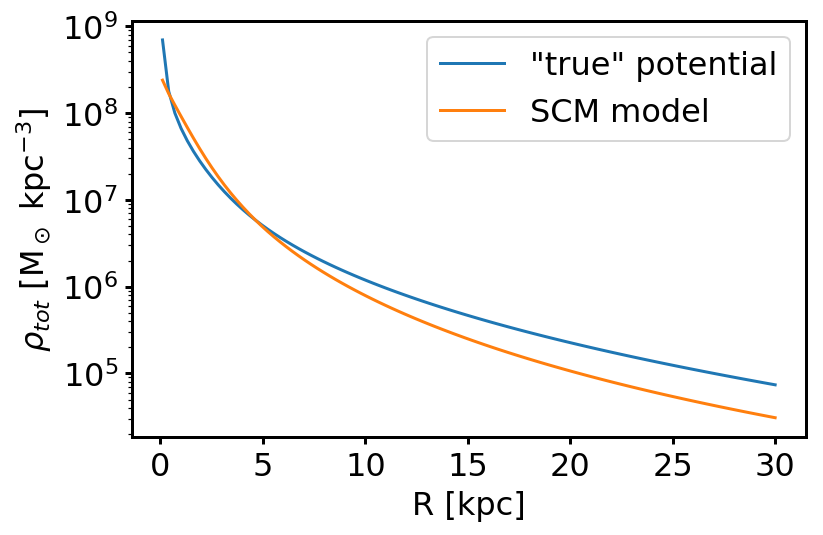

In [22]:
# array of positions at which to evaluate density
R_test = np.linspace(0.1, 30, num = 100)
z_test = np.full(100, 0)
# R = np.sqrt(x**2 + y**2)
R_test_squared = R_test**2
x_test_squared = np.random.sample(100) * R_test_squared
y_test_squared = R_test_squared - x_test_squared
x_test = np.sqrt(x_test_squared)
y_test = np.sqrt(y_test_squared)

x_othertest = np.zeros(100)
y_othertest = np.zeros(100)
z_othertest = np.linspace(0.1, 20, num = 100)

pos = np.array([x_test, y_test, z_test])
pos_test = []
for i in range(len(pos[0])):
    pos_test.append([x_test[i], y_test[i], z_test[i]])

posother = np.array([x_test, y_test, z_test])
pos_othertest = []
for i in range(len(posother[0])):
    pos_othertest.append([x_othertest[i], y_othertest[i], z_othertest[i]])


SCMdens_test = model.potential.density(pos_test)
dens_othertest = model.potential.density(pos_othertest)
potdens_test = sag_pot.density(pos_test)

plt.semilogy(R_test, potdens_test, label = '"true" potential')
plt.semilogy(R_test, SCMdens_test, label = 'SCM model')

plt.xlabel("R [kpc]")
plt.ylabel('$\\rho_{tot}\ [\mathrm{M}_\odot\ \mathrm{kpc}^{-3}] $')
plt.legend()
'''
plt.show()
plt.semilogy(z_othertest, dens_othertest, label = 'at R=0 kpc')
plt.xlabel("z [kpc]")
plt.ylabel('$\\rho_{tot}\ [\mathrm{M}_\odot\ \mathrm{kpc}^{-3}] $')
plt.legend()
'''
plt.show()

/u/milas/conda-envs/auriga/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "



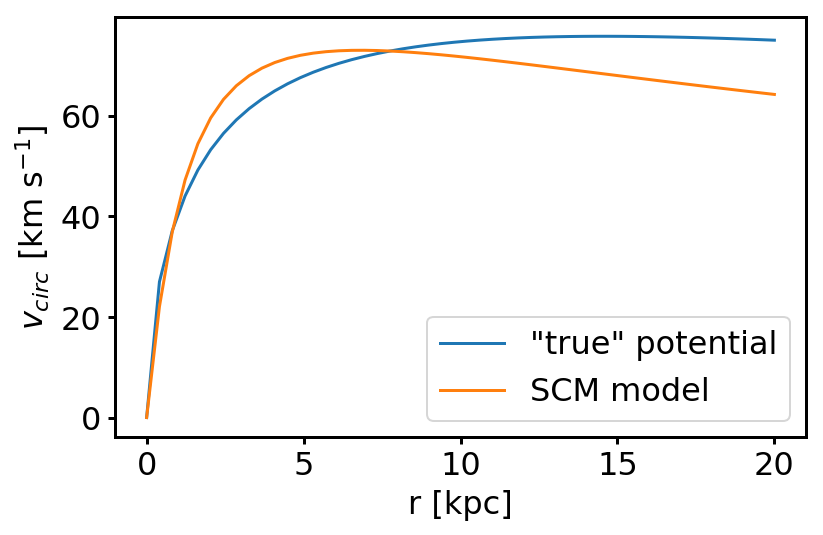

In [23]:
r = np.linspace(0,20)
points = np.column_stack((r, r*0, r*0))
plt.plot(r, np.sqrt(-r*sag_pot.force(points)[:,0]), label = '"true" potential')
plt.plot(r, np.sqrt(-r*model.potential.force(points)[:,0]), label = 'SCM model')

#for pot in model.potential: plt.plot(r, np.sqrt(-r*pot.force(points)[:,0]), label = pot.name())
plt.legend()
plt.xlabel('r [kpc]')
plt.ylabel('$v_{circ}\ [\mathrm{km\ s^{-1}}]$')
plt.show()

Sagittarius comparable GC 6d phase space info 
---

https://arxiv.org/pdf/1301.7069.pdf Belokurov et al. 2014 found debris of Sagittarius at an approximate distance of NGC2491. https://arxiv.org/pdf/1104.3220.pdf Deason et al. 2011 adapted a distance modulus of $(m-M) = \mu = 19.8$ which is a distance of 91.2 kpc.

Its Galactic coordinates are: longitude $180.371213^\circ$ and latitude $25.239416^\circ$.

We use galpy's coordinate trafo to get from lbd to XYZ:

In [24]:
l = 180.371213 * np.pi/180. # in rad
b = 25.239416 * np.pi/180. # in rad
d = 91.2 # in kpc

X_hotstream, Y_hotstream, Z_hotstream = bovy_coords.lbd_to_XYZ(l,b,d, degree=False)

X, Y and Z of the hot stream have to be added to the positions of the Sagittarius sample!

We also use its mean velocity to have an initial guess for that. It has a radial velocity of $-20.2\pm 0.5\mathrm{km/s}$ and proper motions in mas/yr of $pmRA = -6.29,\ pmDEC = -1.19,\ e_{pm} = 0.83$ at RA = 114.535$^\circ$, DEC = +38.882$^\circ$. (https://ui.adsabs.harvard.edu/?#abs/2013A%26A...558A..53K / Kharchenko et al. 2013)

In [25]:
pmra = -6.29 # in mas/yr
pmdec = -1.19 # in mas/yr
v_los = -20.2 # in km/s

ra = 114.535 # in degree
dec = +38.882 # in degree
# first transform pmra / pmdec to galcentric pms
pmll, pmbb = bovy_coords.pmrapmdec_to_pmllpmbb(pmra, pmdec, ra, dec, degree = True, epoch = 2000.0)
vX_hotstream, vY_hotstream, vZ_hotstream = bovy_coords.vrpmllpmbb_to_vxvyvz(v_los, pmll, pmbb, l, b, d, XYZ = False, degree = False)

vX, vY and vZ of the hot stream have to be added to the velocities of the Sagittarius sample!

In [26]:
sagposvel = np.array([X_hotstream, Y_hotstream, Z_hotstream, vX_hotstream, vY_hotstream, vZ_hotstream])

Sample Sag particles
---

In [27]:
SagDMsample = SagDM.sample(10000)
Sagdisksample = Sagdisk.sample(10000)

SagDMsample_final = np.column_stack((SagDMsample[0]+sagposvel, SagDMsample[1]))
Sagdisksample_final = np.column_stack([Sagdisksample[0]+sagposvel, Sagdisksample[1]])

In [30]:
data0 = np.vstack((SagDMsample[0], Sagdisksample[0]))
data1 = np.concatenate((SagDMsample[1], Sagdisksample[1]), axis = None)
parts = (data0, data1)
agama.writeSnapshot('IC_Sag.dat', parts)
#ascii.write(data, 'Sagparticles.dat', names=['x', 'y', 'z', 'vx', 'vy', 'vz','mass'], overwrite = True)


In [29]:
parts[1].shape

(20000,)

pyICs
---